In [1]:
import pandas as pd
import tables
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

# Part 1: Data Preparation

### 1.1 Load HDF5 data using pandas API. The data imported by pandas is a multi-index dataframe where level 0 is the unique patient encounter identifier and index level 1 is the time of each measurement in units of hours since first measurment 

In [2]:
x_train = pd.read_hdf('X_train.hdf')
x_test = pd.read_hdf('X_test.hdf')

y_train = pd.read_hdf('y_train.hdf')
y_test = pd.read_hdf('y_test.hdf')

In [3]:
x_train

ABG Base excess (mEq/L)  ABG FiO2  ABG HCO3 (mEq/L)  \
encounterID absoluteTime                                                        
8           0.000000                          NaN       NaN               NaN   
            0.250000                          NaN       NaN               NaN   
            0.500000                          NaN       NaN               NaN   
            0.583333                          NaN       NaN               NaN   
            0.750000                          NaN       NaN               NaN   
...                                           ...       ...               ...   
16259       87.000000                         NaN       NaN               NaN   
            87.083336                         NaN       NaN               NaN   
            87.666664                         NaN       NaN               NaN   
            88.000000                         NaN       NaN               NaN   
            89.000000                         NaN       NaN               NaN   

                          ABG O2 sat (%)  ABG PCO2 (mmHg)  ABG PO2 (mmHg)  \
encounterID absoluteTime                                                    
8           0.000000                 NaN              NaN             NaN   
            0.250000                 NaN              NaN             NaN   
            0.500000                 NaN              NaN             NaN   
            0.583333                 NaN              NaN             NaN   
            0.750000                 NaN              NaN             NaN   
...                                  ...              ...             ...   
16259       87.000000                NaN              NaN             NaN   
            87.083336                NaN              NaN             NaN   
            87.666664                NaN              NaN             NaN   
            88.000000                NaN              NaN             NaN   
            89.000000                NaN              NaN             NaN   

                          ABG TCO2 (mEq/L)  ABG pH  ALT (SGPT) (units/L)  \
encounterID absoluteTime                                                   
8           0.000000                   NaN     NaN                   NaN   
            0.250000                   NaN     NaN                   NaN   
            0.500000                   NaN     NaN                   NaN   
            0.583333                   NaN     NaN                   NaN   
            0.750000                   NaN     NaN                   NaN   
...                                    ...     ...                   ...   
16259       87.000000                  NaN     NaN                   NaN   
            87.083336                  NaN     NaN                   NaN   
            87.666664                  NaN     NaN                   NaN   
            88.000000                  NaN     NaN                   NaN   
            89.000000                  NaN     NaN                   NaN   

                          AST (SGOT) (units/L)  ...  Vasopressin  Vecuronium  \
encounterID absoluteTime                        ...                            
8           0.000000                       NaN  ...          NaN         NaN   
            0.250000                       NaN  ...          NaN         NaN   
            0.500000                       NaN  ...          NaN         NaN   
            0.583333                       NaN  ...          NaN         NaN   
            0.750000                       NaN  ...          NaN         NaN   
...                                        ...  ...          ...         ...   
16259       87.000000                      NaN  ...          NaN         NaN   
            87.083336                      NaN  ...          NaN         NaN   
            87.666664                      NaN  ...          NaN         NaN   
            88.000000                      NaN  ...          NaN         NaN   
            89.000000

### 1.2 Find how many patient encounters there are in the training set; how many timestamps are measured in total; and how many types of measurements are documented

In [4]:
'''
It is easy to find how many timestamps are measured in total 
and how many types of measurements are documented. 

The number of timestamps is just the legth of the data set (or 
the first dimension)

The number types of measuremntes is the number of columns. (The
second dimension)
'''
x_train.shape

(1113529, 265)

In [5]:
# There are 1,113,529 timestamps in total 

# There are 265 types of measurements

In [6]:
'''
To find the number of patient encounters, we need to find the 
number of patient encounterIDs 
'''
# Get a list of all the patient encounterIDs 

# Isolate the indices
mi = x_train.index
print(mi)

# mi includes bout the encounterIDs and the absolute time 
# Isolate the encounterIDs
id_array = mi.get_level_values(level=0).to_numpy()


MultiIndex([(    8,                0.0),
            (    8,               0.25),
            (    8,                0.5),
            (    8, 0.5833333134651184),
            (    8,               0.75),
            (    8, 1.3833333253860474),
            (    8,               1.75),
            (    8,               2.25),
            (    8,                2.5),
            (    8,               2.75),
            ...
            (16259,               84.0),
            (16259,               85.0),
            (16259,  85.08333587646484),
            (16259,  85.46666717529297),
            (16259,               86.0),
            (16259,               87.0),
            (16259,  87.08333587646484),
            (16259,  87.66666412353516),
            (16259,               88.0),
            (16259,               89.0)],
           names=['encounterID', 'absoluteTime'], length=1113529)


In [7]:
# The id_array repeats the id for each timestamp. 
# We want a list of each id, not repeated. 

unique_ids = []
for id_val in range(len(id_array)-1):
    # compare each id in the list
    if id_array[id_val] != id_array[id_val+1]:
        unique_ids.append(id_array[id_val])
    # this excludes the last id, becuase it is not compared with another value
# add the last id
unique_ids.append(id_array[-1])

In [8]:
# Find the length to find the number of encounterIDs
len(unique_ids)

5000

In [9]:
# There are 5,000 patient encounterIDs 

### 1.3 For each patient encounter, find how many time measurements were taken, and plot a histogram showing the number of times each patient encounter is measured.

In [10]:
'''
To find the number of time measurements taken for each patient
encounter we can slice the training set for each encounter, and 
find its length. 
'''
# Use the pandas IdexSlice function to slice the training set
idx = pd.IndexSlice 
# check that it works
x_train.loc[idx[8]]

,ABG Base excess (mEq/L),ABG FiO2,ABG HCO3 (mEq/L),ABG O2 sat (%),ABG PCO2 (mmHg),ABG PO2 (mmHg),ABG TCO2 (mEq/L),ABG pH,ALT (SGPT) (units/L),AST (SGOT) (units/L),...,Vasopressin,Vecuronium,Ventilator rate (bpm),VerbalResponse,Vitamin E,Volume Tidal,Voriconazole,Weight,White blood cell count (K/uL),deltat
absoluteTime,,,,,,,,,,,,,,,,,,,,,
0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,0.250000
0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000
0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.083333
0.583333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166667
0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,0.633333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000
150.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,25.0,NaN,0.016667
150.766663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.233333


In [11]:
# Fill a list with the number of timestamps for each patient encounter
num_time_measurements = []
for id_val in unique_ids:
    length = len(x_train.loc[idx[id_val]])
    num_time_measurements.append(length)

Text(0.5, 1.0, 'Bar Graph of EncounterIDs and Number of Timestamps')

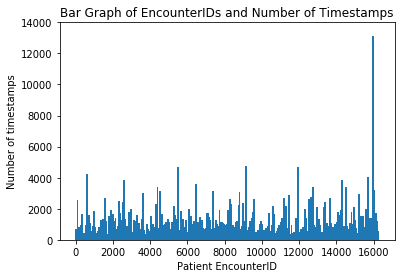

In [12]:
'''
To display the number of timestamps for each patient encounter, create
a bar graph of the encounter IDs and the timestamps
'''
plt.bar(unique_ids, num_time_measurements, width=100)
plt.ylim(0,14000)
plt.xlabel('Patient EncounterID')
plt.ylabel('Number of timestamps')
plt.title('Bar Graph of EncounterIDs and Number of Timestamps')

Text(0.5, 1.0, 'Histogram of Number of timestamps')

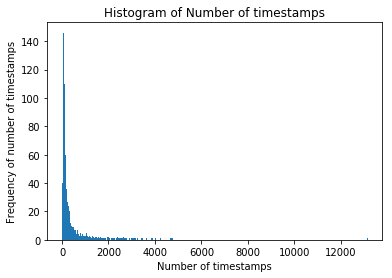

In [13]:
'''
Plot a histogram of the number of timestamps, letting the bin size
be the number of encounterIDs, 5000
'''
plt.hist(num_time_measurements, bins = len(unique_ids), width=50)
plt.xlabel('Number of timestamps')
plt.ylabel('Frequency of number of timestamps')
plt.title('Histogram of Number of timestamps')

### 1.4 Perform data normalization for all numerical measurements. 

In [14]:
'''
We want to normalized the data so that all the values are between 0-1. 
'''
# Nomralize
x_min = x_train.min()
x_max = x_train.max()

# Normalized the training data
x_train = (x_train - x_min)/(x_max - x_min)

# We also need to normalize the testing data, using the mins and max from training
x_test = (x_test - x_min)/(x_max - x_min)

### 1.5 For each patient encounter, fill in missing data points using forward filling, i.e., use the last measurement for all missing measurements till the next time stamp when anothe measurement is made. If there was not a previous measurement, fill in missing point(s) with zeros 

In [15]:
# Use forward fill method in fillna 
x_train = x_train.fillna(method='ffill')

In [16]:
# Look to the end of the training data to see that it worked
x_train

ABG Base excess (mEq/L)  ABG FiO2  ABG HCO3 (mEq/L)  \
encounterID absoluteTime                                                        
8           0.000000                          NaN       NaN               NaN   
            0.250000                          NaN       NaN               NaN   
            0.500000                          NaN       NaN               NaN   
            0.583333                          NaN       NaN               NaN   
            0.750000                          NaN       NaN               NaN   
...                                           ...       ...               ...   
16259       87.000000                    0.464103   0.20202          0.333333   
            87.083336                    0.464103   0.20202          0.333333   
            87.666664                    0.464103   0.20202          0.333333   
            88.000000                    0.464103   0.20202          0.333333   
            89.000000                    0.464103   0.20202          0.333333   

                          ABG O2 sat (%)  ABG PCO2 (mmHg)  ABG PO2 (mmHg)  \
encounterID absoluteTime                                                    
8           0.000000                 NaN              NaN             NaN   
            0.250000                 NaN              NaN             NaN   
            0.500000                 NaN              NaN             NaN   
            0.583333                 NaN              NaN             NaN   
            0.750000                 NaN              NaN             NaN   
...                                  ...              ...             ...   
16259       87.000000               0.89         0.205021        0.073225   
            87.083336               0.89         0.205021        0.073225   
            87.666664               0.89         0.205021        0.073225   
            88.000000               0.89         0.205021        0.073225   
            89.000000               0.89         0.205021        0.073225   

                          ABG TCO2 (mEq/L)    ABG pH  ALT (SGPT) (units/L)  \
encounterID absoluteTime                                                     
8           0.000000                   NaN       NaN                   NaN   
            0.250000                   NaN       NaN                   NaN   
            0.500000                   NaN       NaN                   NaN   
            0.583333                   NaN       NaN                   NaN   
            0.750000                   NaN       NaN                   NaN   
...                                    ...       ...                   ...   
16259       87.000000                 0.44  0.730159               0.00175   
            87.083336                 0.44  0.730159               0.00175   
            87.666664                 0.44  0.730159               0.00175   
            88.000000                 0.44  0.730159               0.00175   
            89.000000                 0.44  0.730159               0.00175   

                          AST (SGOT) (units/L)  ...  Vasopressin  Vecuronium  \
encounterID absoluteTime                        ...                            
8           0.000000                       NaN  ...          NaN         NaN   
            0.250000                       NaN  ...          NaN         NaN   
            0.500000                       NaN  ...          NaN         NaN   
            0.583333                       NaN  ...          NaN         NaN   
            0.750000                       NaN  ...          NaN         NaN   
...                                        ...  ...          ...         ...   
16259       87.000000                  0.00229  ...          NaN         NaN   
            87.083336                  0.00229  ...          NaN         NaN   
            87.666664                  0.00229  ...          NaN         NaN   
            88.000000                  0.00229  ...          NaN         Na

In [17]:
# It worked. Now fill the rest of the NaN with zeros
x_train = x_train.fillna(0)

In [18]:
# Check that it worked
x_train

ABG Base excess (mEq/L)  ABG FiO2  ABG HCO3 (mEq/L)  \
encounterID absoluteTime                                                        
8           0.000000                     0.000000   0.00000          0.000000   
            0.250000                     0.000000   0.00000          0.000000   
            0.500000                     0.000000   0.00000          0.000000   
            0.583333                     0.000000   0.00000          0.000000   
            0.750000                     0.000000   0.00000          0.000000   
...                                           ...       ...               ...   
16259       87.000000                    0.464103   0.20202          0.333333   
            87.083336                    0.464103   0.20202          0.333333   
            87.666664                    0.464103   0.20202          0.333333   
            88.000000                    0.464103   0.20202          0.333333   
            89.000000                    0.464103   0.20202          0.333333   

                          ABG O2 sat (%)  ABG PCO2 (mmHg)  ABG PO2 (mmHg)  \
encounterID absoluteTime                                                    
8           0.000000                0.00         0.000000        0.000000   
            0.250000                0.00         0.000000        0.000000   
            0.500000                0.00         0.000000        0.000000   
            0.583333                0.00         0.000000        0.000000   
            0.750000                0.00         0.000000        0.000000   
...                                  ...              ...             ...   
16259       87.000000               0.89         0.205021        0.073225   
            87.083336               0.89         0.205021        0.073225   
            87.666664               0.89         0.205021        0.073225   
            88.000000               0.89         0.205021        0.073225   
            89.000000               0.89         0.205021        0.073225   

                          ABG TCO2 (mEq/L)    ABG pH  ALT (SGPT) (units/L)  \
encounterID absoluteTime                                                     
8           0.000000                  0.00  0.000000               0.00000   
            0.250000                  0.00  0.000000               0.00000   
            0.500000                  0.00  0.000000               0.00000   
            0.583333                  0.00  0.000000               0.00000   
            0.750000                  0.00  0.000000               0.00000   
...                                    ...       ...                   ...   
16259       87.000000                 0.44  0.730159               0.00175   
            87.083336                 0.44  0.730159               0.00175   
            87.666664                 0.44  0.730159               0.00175   
            88.000000                 0.44  0.730159               0.00175   
            89.000000                 0.44  0.730159               0.00175   

                          AST (SGOT) (units/L)  ...  Vasopressin  Vecuronium  \
encounterID absoluteTime                        ...                            
8           0.000000                   0.00000  ...          0.0         0.0   
            0.250000                   0.00000  ...          0.0         0.0   
            0.500000                   0.00000  ...          0.0         0.0   
            0.583333                   0.00000  ...          0.0         0.0   
            0.750000                   0.00000  ...          0.0         0.0   
...                                        ...  ...          ...         ...   
16259       87.000000                  0.00229  ...          0.0         0.0   
            87.083336                  0.00229  ...          0.0         0.0   
            87.666664                  0.00229  ...          0.0         0.0   
            88.000000                  0.00229  ...          0.0         0.

In [19]:
# It worked. 

### 1.6 Set the maximum length of sequence for each patient encounter to the 90th percentile of length. Truncate or zero-pad to the same maximum length for all patient encounter sequences. 


In [20]:
# First used the num_time_measurements list to find the 90th precentile length
percentile = np.percentile(num_time_measurements, 90)
print(percentile)

523.1000000000004


In [21]:
# We want an integer number 
percentile = int(percentile)
print(percentile)

523


In [22]:
# Use the pad_sequences keras function to truncate and pad the sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [23]:
'''
We need to change the way the data is structured to be able to use 
pad_sequences. We are going to construnct a nested list that has the 
dimensions (5,000x265x523), so each id_encounter will be a block of data
that stores each column from the training data in a list, which has the 
length 523, the 90th precentile of length. 

To do this, we need to create a loop that iterates over every encounterID. 
'''
id_block_arrays = []
counter = 0
for i in unique_ids:
    id_block = np.array(x_train.loc[idx[i]])
    id_block_arrays.append(id_block)
    
    counter += 1
    print('Processed: ', counter)
    
x_train_pad = pad_sequences(id_block_arrays, maxlen=percentile, value=0, 
                            dtype='float32', truncating='post', padding='post')

Processed:  1
Processed:  2
Processed:  3
Processed:  4
Processed:  5
Processed:  6
Processed:  7
Processed:  8
Processed:  9
Processed:  10
Processed:  11
Processed:  12
Processed:  13
Processed:  14
Processed:  15
Processed:  16
Processed:  17
Processed:  18
Processed:  19
Processed:  20
Processed:  21
Processed:  22
Processed:  23
Processed:  24
Processed:  25
Processed:  26
Processed:  27
Processed:  28
Processed:  29
Processed:  30
Processed:  31
Processed:  32
Processed:  33
Processed:  34
Processed:  35
Processed:  36
Processed:  37
Processed:  38
Processed:  39
Processed:  40
Processed:  41
Processed:  42
Processed:  43
Processed:  44
Processed:  45
Processed:  46
Processed:  47
Processed:  48
Processed:  49
Processed:  50
Processed:  51
Processed:  52
Processed:  53
Processed:  54
Processed:  55
Processed:  56
Processed:  57
Processed:  58
Processed:  59
Processed:  60
Processed:  61
Processed:  62
Processed:  63
Processed:  64
Processed:  65
Processed:  66
Processed:  67
Proc

In [24]:
x_train_pad.shape

(5000, 523, 265)

In [25]:
'''
We changed the length of the x_train columns, which means we also need
to change the length of the labels (the y_train). 
'''
y_train_pad = []

for i in unique_ids: 
    # Get the data from the ID
    id_array = np.array(y_train.loc[idx[i]]['mortalityResponse'])
    
    # The mortalityResponce is same for all time stamps. Pad with this value
    value = int(id_array[0])
    id_array_pad = pad_sequences([id_array], maxlen=percentile, 
                                 value=value, truncating='post', padding='post')
    y_train_pad.append(id_array_pad)
    


In [26]:
y_train_pad = np.array(y_train_pad)

In [27]:
y_train_pad.shape

(5000, 1, 523)

In [28]:
id_array_pad.shape

(1, 523)

In [29]:
len(y_train_pad[0][0])

523

In [30]:
np.save('x_train.npy', x_train_pad)

In [31]:
np.save('y_train.npy', y_train_pad )

In [32]:
'''
We also need to restructure the testing data. To do so, we will follow 
the same method that we used for the training data. 
'''

# Get a list of the encouterIDs
mi_test = x_test.index
print(mi_test)

# Isolate the encounterIDs
id_array_test = mi_test.get_level_values(level=0).to_numpy()


MultiIndex([(   19,                 0.0),
            (   19, 0.01666666753590107),
            (   19,  0.7666666507720947),
            (   19,  0.9833333492279053),
            (   19,                 1.0),
            (   19,                 2.0),
            (   19,   2.866666555404663),
            (   19,                 3.0),
            (   19,                3.25),
            (   19,                 3.5),
            ...
            (16266,   6.666666507720947),
            (16266,                 7.0),
            (16266,   7.666666507720947),
            (16266,   8.350000381469727),
            (16266,   8.666666984558105),
            (16266,   8.833333015441895),
            (16266,   9.666666984558105),
            (16266,  10.666666984558105),
            (16266,               11.25),
            (16266,  11.666666984558105)],
           names=['encounterID', 'absoluteTime'], length=82251)


In [33]:
# Need to fill all the NaNs in the test set as well

x_test = x_test.fillna(method='ffill')

In [34]:
x_test

ABG Base excess (mEq/L)  ABG FiO2  ABG HCO3 (mEq/L)  \
encounterID absoluteTime                                                        
19          0.000000                          NaN       NaN               NaN   
            0.016667                          NaN       NaN               NaN   
            0.766667                          NaN       NaN               NaN   
            0.983333                          NaN       NaN               NaN   
            1.000000                          NaN       NaN               NaN   
...                                           ...       ...               ...   
16266       8.833333                     0.298718  0.393939            0.1875   
            9.666667                     0.298718  0.393939            0.1875   
            10.666667                    0.298718  0.393939            0.1875   
            11.250000                    0.298718  0.393939            0.1875   
            11.666667                    0.298718  0.393939            0.1875   

                          ABG O2 sat (%)  ABG PCO2 (mmHg)  ABG PO2 (mmHg)  \
encounterID absoluteTime                                                    
19          0.000000                 NaN              NaN             NaN   
            0.016667                 NaN              NaN             NaN   
            0.766667                 NaN              NaN             NaN   
            0.983333                 NaN              NaN             NaN   
            1.000000                 NaN              NaN             NaN   
...                                  ...              ...             ...   
16266       8.833333                0.96         0.129707        0.117688   
            9.666667                0.96         0.129707        0.117688   
            10.666667               0.96         0.129707        0.117688   
            11.250000               0.96         0.129707        0.117688   
            11.666667               0.96         0.129707        0.117688   

                          ABG TCO2 (mEq/L)   ABG pH  ALT (SGPT) (units/L)  \
encounterID absoluteTime                                                    
19          0.000000                   NaN      NaN                   NaN   
            0.016667                   NaN      NaN                   NaN   
            0.766667                   NaN      NaN                   NaN   
            0.983333                   NaN      NaN                   NaN   
            1.000000                   NaN      NaN                   NaN   
...                                    ...      ...                   ...   
16266       8.833333              0.253333  0.68254              0.000667   
            9.666667              0.253333  0.68254              0.000667   
            10.666667             0.253333  0.68254              0.000667   
            11.250000             0.253333  0.68254              0.000667   
            11.666667             0.253333  0.68254              0.000667   

                          AST (SGOT) (units/L)  ...  Vasopressin  Vecuronium  \
encounterID absoluteTime                        ...                            
19          0.000000                       NaN  ...          NaN         NaN   
            0.016667                       NaN  ...          NaN         NaN   
            0.766667                       NaN  ...          NaN         NaN   
            0.983333                       NaN  ...          NaN         NaN   
            1.000000                       NaN  ...          NaN         NaN   
...                                        ...  ...          ...         ...   
16266       8.833333                  0.001033  ...          NaN         NaN   
            9.666667                  0.001033  ...          NaN         NaN   
            10.666667                 0.001033  ...          NaN         NaN   
            11.250000                 0.001033  ...          NaN         NaN   
        

In [35]:
x_test = x_test.fillna(0)

In [36]:
# The id_array repeats the id for each timestamp. 
# We want a list of each id, not repeated. 

unique_ids_test = []
for id_val in range(len(id_array_test)-1):
    # compare each id in the list
    if id_array_test[id_val] != id_array_test[id_val+1]:
        unique_ids_test.append(id_array_test[id_val])
    # this excludes the last id, becuase it is not compared with another value
# add the last id
unique_ids_test.append(id_array_test[-1])

In [37]:
len(unique_ids_test)

2690

In [38]:
# Fill a list with the number of timestamps for each patient encounter
num_time_measurements_test = []
for id_val in unique_ids_test:
    length = len(x_test.loc[idx[id_val]])
    num_time_measurements_test.append(length)

In [39]:
len(num_time_measurements_test)

2690

In [40]:
max_len_test = max(num_time_measurements_test)

In [41]:
max_len_test

110

In [43]:
'''
x_test and y_test must be the same shape as x_train and y_train, respectively,
for training.
Thus, they must be 3-D arrays, with shape (5000x523x256) and (5000x1x523)
'''


id_block_arrays = []

for i in unique_ids_test:
    id_block = np.array(x_test.loc[idx[i]])
    id_block_arrays.append(id_block)
    
    
x_test_pad = pad_sequences(id_block_arrays, maxlen=percentile, value=0, 
                            dtype='float32', truncating='post', padding='post')

In [44]:
x_test_pad[0]

array([[0.        , 0.        , 0.        , ..., 0.21467991, 0.        ,
        0.00420168],
       [0.        , 0.        , 0.        , ..., 0.21467991, 0.        ,
        0.18907563],
       [0.        , 0.        , 0.        , ..., 0.21467991, 0.        ,
        0.05462185],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [45]:
y_test_pad = []

for i in unique_ids_test: 
    # Get the data from the ID
    id_array = np.array(y_test.loc[idx[i]]['mortalityResponse'])
    
    # The mortalityResponce is same for all time stamps. Pad with this value
    value = int(id_array[0])
    id_array_pad = pad_sequences([id_array], maxlen=percentile, 
                                 value=value, truncating='post', padding='post')
    y_test_pad.append(id_array_pad)

In [46]:
y_test_pad = np.array(y_test_pad)

In [47]:
x_test_pad.shape

(2690, 523, 265)

In [48]:
y_test_pad.shape

(2690, 1, 523)

In [49]:
np.save('y_test.npy', y_test_pad)
np.save('x_test.npy', x_test_pad)

In [ ]:
# Squeeze for ROC. model eval should be based on one patient, not 
# each time stamp. 